<a href="https://colab.research.google.com/github/zmunk/movie-reviews-sentiment-analysis/blob/master/Movie_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking if gpu is connected
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Imports

In [0]:
!pip install gdown
!pip install tensorflow_text
!pip install wordcloud
!pip install tensorflow-gpu

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!gdown --id 1jNsxpadd4WJgu1wBkOBdEY3-9INzP4rY --output train.zip
!unzip -q train.zip

Downloading...
From: https://drive.google.com/uc?id=1jNsxpadd4WJgu1wBkOBdEY3-9INzP4rY
To: /content/data.zip
100% 1.34M/1.34M [00:00<00:00, 6.27MB/s]
replace train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
data.zip  sample_data  train.tsv


In [22]:
!gdown --id 1FigbxI95OHqEDmcIbE5yFv9YhNH_Csk8 --output test.zip
!unzip -q test.zip

Downloading...
From: https://drive.google.com/uc?id=1FigbxI95OHqEDmcIbE5yFv9YhNH_Csk8
To: /content/test.zip
100% 506k/506k [00:00<00:00, 3.37MB/s]


In [0]:
!ls

# Preprocessing

Training data

In [8]:
train_df = pd.read_csv("train.tsv", sep="\t")
train_df.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

Test data

In [0]:
test_df = pd.read_csv("test.tsv", sep="\t")

Encode sentiment into 5 columns

In [0]:
from sklearn.preprocessing import OneHotEncoder
y_train = OneHotEncoder(sparse=False).fit_transform(
    train_df.Sentiment.to_numpy().reshape(-1, 1)
)

In [85]:
y_train.shape

(156060, 5)

### Universal Sentence Encoder

In [0]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

We embed each phrase in the training set with the universal sentence encoder.

In [86]:
from os import path
import pickle

filename = "phrases_x_train.pkl"

if path.exists(filename):
  X_train = pickle.load(open(filename, "rb"))
else:
  X_train = []
  for phrase in tqdm(train_df.Phrase, position=0, leave=True):
    embedding = use([phrase])
    phrase_embedding = tf.reshape(embedding, [-1]).numpy()
    X_train.append(phrase_embedding)
  X_train = np.array(X_train)
  pickle.dump(X_train, open(filename, "wb"))

100%|██████████| 156060/156060 [13:44<00:00, 189.31it/s]


We embed each phrase in the test set with the universal sentence encoder.

In [0]:
test_embeddings = use(test_df["Phrase"])

# Sentiment Analysis

Two dense layers with 256 and 128 nodes, each one followed by a dropout layer, and finally a softmax activation layer for the five categories.

In [0]:
model = keras.Sequential()

model.add(
    keras.layers.Dense(
        units=256,
        input_shape=(X_train.shape[1],),
        activation='relu'
    )
)

model.add(keras.layers.Dropout(rate=0.5))

model.add(
    keras.layers.Dense(
        units=128,
        activation='relu'
    )
)

model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(5, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [88]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Train on 140454 samples, validate on 15606 samples
Epoch 1/10
140454/140454 [==============================] - 29s 208us/sample - loss: 0.9678 - accuracy: 0.6022 - val_loss: 0.9742 - val_accuracy: 0.5899
Epoch 2/10
140454/140454 [==============================] - 29s 207us/sample - loss: 0.9236 - accuracy: 0.6201 - val_loss: 0.9654 - val_accuracy: 0.5921
Epoch 3/10
140454/140454 [==============================] - 28s 202us/sample - loss: 0.9020 - accuracy: 0.6282 - val_loss: 0.9658 - val_accuracy: 0.5948
Epoch 4/10
140454/140454 [==============================] - 28s 202us/sample - loss: 0.8844 - accuracy: 0.6334 - val_loss: 0.9735 - val_accuracy: 0.5927
Epoch 5/10
140454/140454 [==============================] - 28s 201us/sample - loss: 0.8699 - accuracy: 0.6405 - val_loss: 0.9715 - val_accuracy: 0.5946
Epoch 6/10
140454/140454 [==============================] - 29s 207us/sample - loss: 0.8580 - accuracy: 0.6450 - val_loss: 0.9704 - val_accuracy: 0.5987
Epoch 7/10
140454/140454 [=====

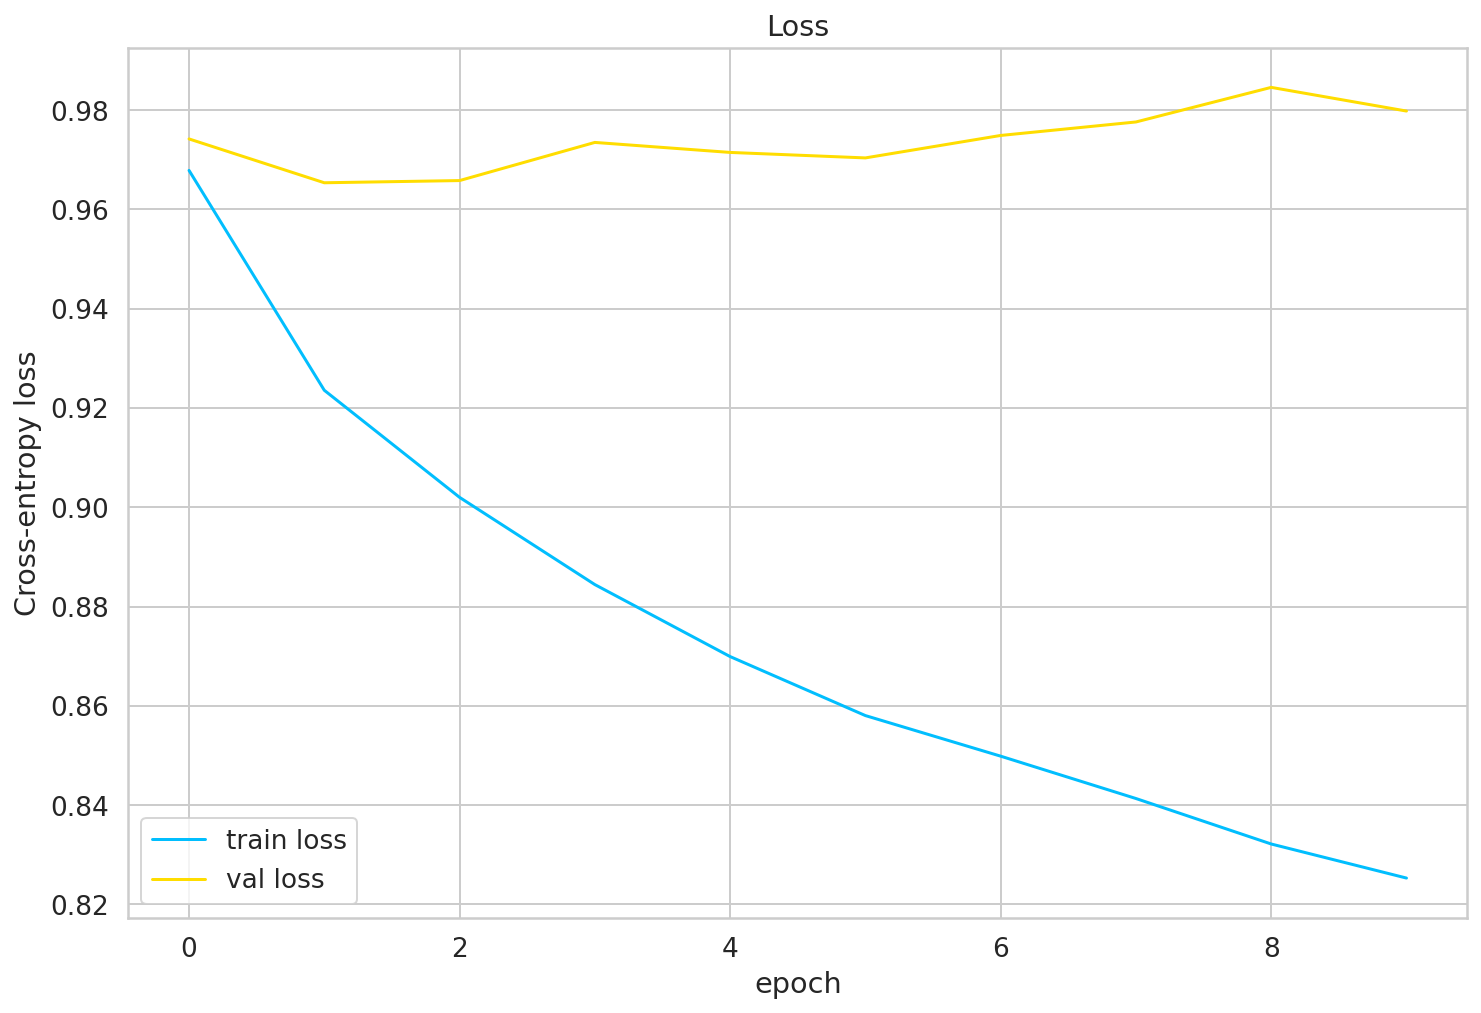

In [111]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Loss")
plt.legend()

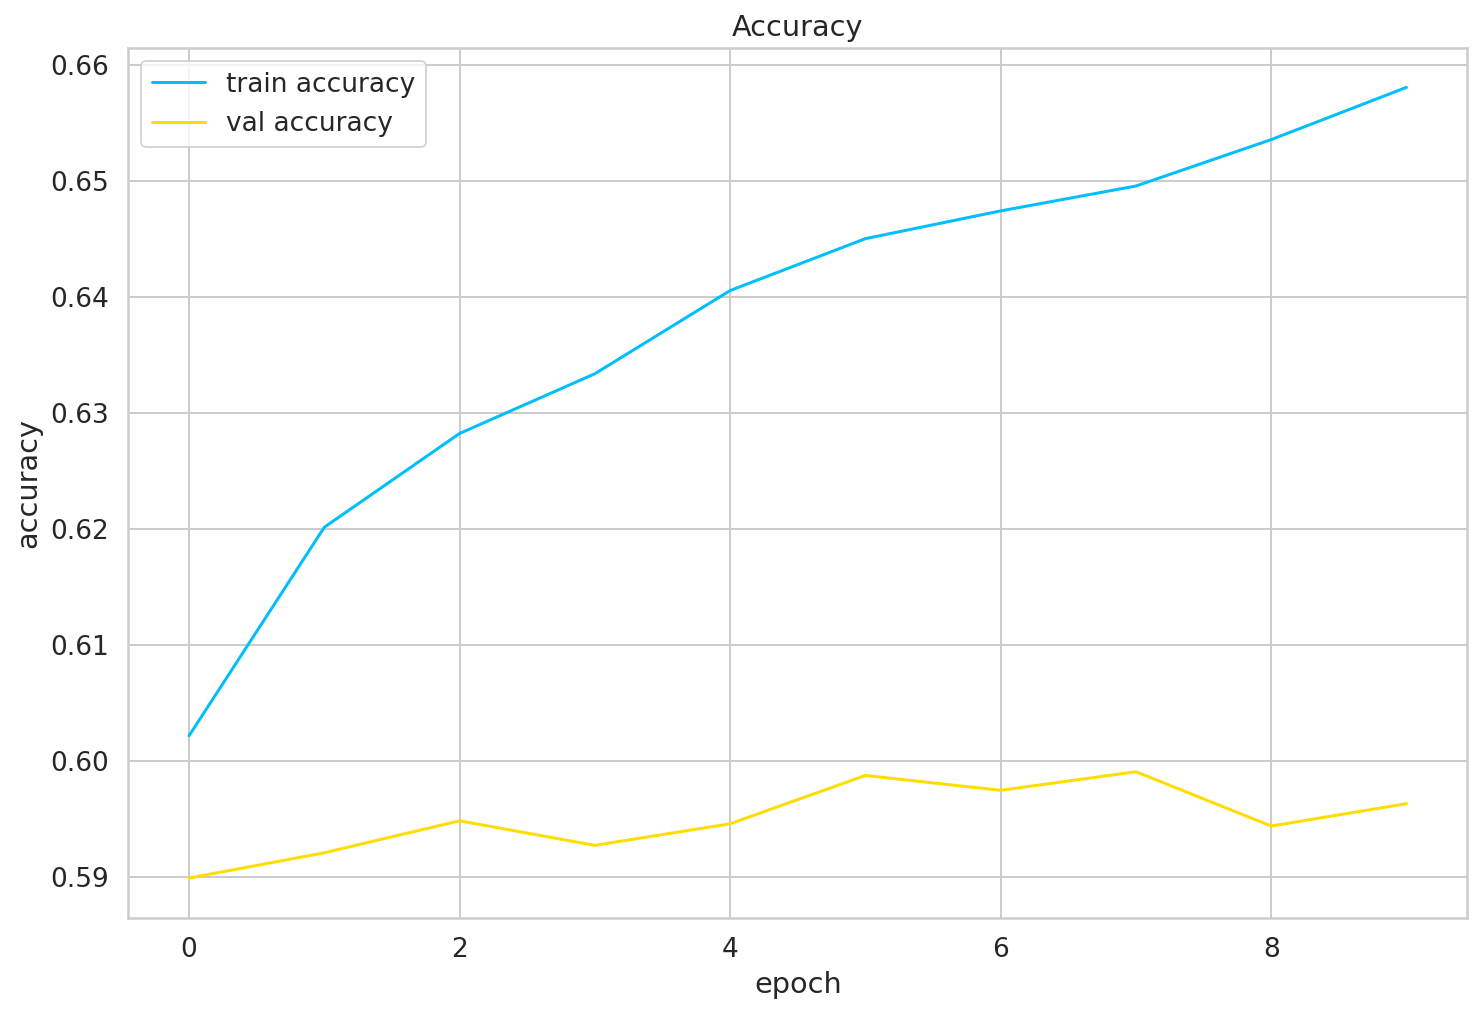

In [110]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()

## Prediction

In [0]:
  test_df["Sentiment"] = np.argmax(model.predict(test_embeddings), axis=1)

In [0]:
predictions_df = test_df[["PhraseId", "Sentiment"]]
predictions_df.to_csv("predictions.csv", index=False)

In [0]:
from google.colab import files

files.download("predictions.csv")